In [1]:
import healpy as hp
from scipy import interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
from pixell import enmap,curvedsky,utils,powspec,enplot
from pixell import reproject as rp
import matplotlib as mpl
import coop_post_processing as cpp
from astropy.io import fits
from astropy import units as u
from scipy import signal
from astropy.cosmology import Planck15 as cosmo, z_at_value
import pickle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import math
# set plot params
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 12})


mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 140


[1657211241.487203] [kingcrab:68267:0]        ib_iface.c:1035 UCX  ERROR ibv_create_cq(cqe=4096) failed: Cannot allocate memory


[kingcrab:68267] pml_ucx.c:309  Error: Failed to create UCP worker


In [2]:
g = hp.read_map("/mnt/raid-cita/mlokken/GRF_buzzspec/grf_gfield_buzzardspec_zbin1_0.fits")

In [3]:
y = hp.read_map("/mnt/raid-cita/mlokken/GRF_buzzspec/grf_yfield_buzzardspec_zbin1_0.fits")

In [9]:
gsmth = hp.sphtfunc.smoothing(g, sigma=np.deg2rad(0.1))

In [10]:
ysmth = hp.sphtfunc.smoothing(y, sigma=np.deg2rad(0.1))

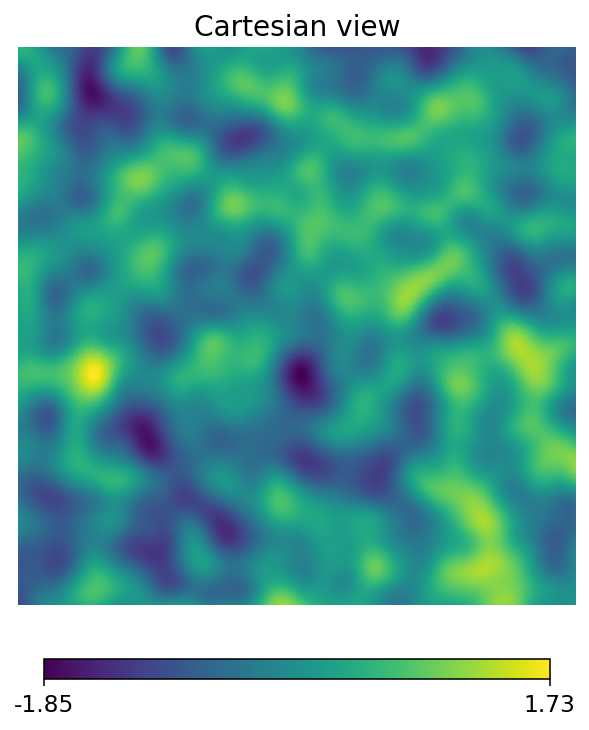

In [11]:
lonra = [-2,2]
latra = [-2,2]
hp.cartview(gsmth, lonra=lonra, latra=latra)

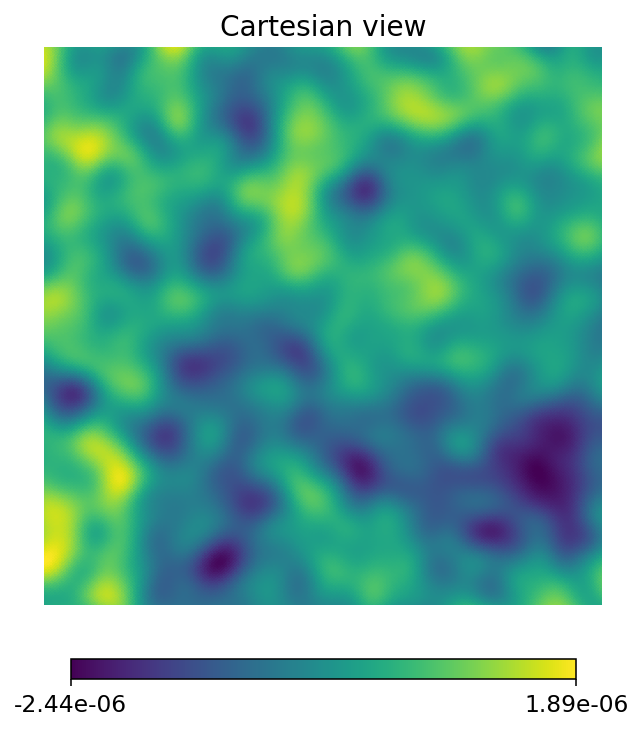

In [12]:
hp.cartview(ysmth, lonra=lonra, latra=latra)


In [2]:
nside = 4096
mode = "Buzzard"


In [3]:
def get_hp_od_map(nside, ra, dec, smth, mask):
    map   = np.zeros((hp.nside2npix(nside)))
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    weight = 1.
    np.add.at(map, pix, weight)
    masked_map = map * mask
    mean = sum(masked_map)/sum(mask)
    newmap   = map/mean - 1
    newmap_masked = newmap * mask
    print("Mean of number density map: ", mean)
    print("Mean of overdensity map: ", sum(newmap_masked)/sum(mask))
    hp.mollview(newmap_masked)
    if smth != 0:
        smthmap = hp.sphtfunc.smoothing(newmap, fwhm = np.deg2rad(smth))
    else:
        smthmap = newmap
    return smthmap

def get_hp_map(nside, ra, dec, mask):
    map   = np.zeros((hp.nside2npix(nside)))
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    weight = 1.
    np.add.at(map, pix, weight)
    masked_map = map * mask
    hp.mollview(masked_map)
    map_mean = sum(masked_map)/sum(mask)
    newmap = masked_map-map_mean
    hp.mollview(newmap*mask)
    return map_mean, newmap*mask

def get_cls(map1, nside, map2=None):
    print("Doing cross correlations...\n")
    if map2 is not None:
        xcorr  = hp.anafast(map1, map2, pol=False)
    else:
        xcorr = hp.anafast(map1)
    ells = np.arange(0, 3*nside)
    return(ells, xcorr)

def get_fullinfo(file):
    info = np.loadtxt(file)
    richness = info[:,0]; z = info[:,1]; ra = info[:,2]; dec = info[:,3]
    return richness, z, ra, dec

def get_yaxis(ell, cl):
    return cl*ell*(ell+1)/(2*np.pi)

def mov_avg(curve, nsmth):
    # take values starting from nsmth
    smth_curve = np.copy(curve)
    for i in range(len(curve)):
        if i > nsmth and i < len(curve)-nsmth:
            avg = np.mean(curve[i-nsmth:i+nsmth])
            smth_curve[i] = avg
        elif i < nsmth:
            smth_curve[i] = np.mean(curve[0:i+nsmth])
        elif i > nsmth:
            smth_curve[i] = np.mean(curve[i-nsmth:])
    return smth_curve

def get_theta_phi(txtfile):
    file = np.loadtxt(txtfile)
    theta = file[:,0]
    phi   = file[:,1]
    return(theta,phi)

def lim(ra, dec, z, rarange, decrange, chirange, lam=False, lamdas=None):
    in_box = (ra>rarange[0]) & (ra < rarange[1]) & (dec>decrange[0]) & (dec < decrange[1])
    zmin = z_at_value(cosmo.comoving_distance, chirange[0]*u.Mpc)
    zmax = z_at_value(cosmo.comoving_distance, chirange[1]*u.Mpc)
    inz  = (z > zmin) & (z < zmax)
    ra     = ra[in_box & inz]
    dec    = dec[in_box & inz]
    if lam:
        return ra, dec, lamdas[in_box & inz]
    else:
        return ra,dec

def mask_map(map):
    mask_map = np.ones(hp.nside2npix(nside))
    all_pix = np.arange(hp.nside2npix(nside))
    theta,phi = hp.pix2ang(nside, all_pix)
#     maxtheta = 1.64454
#     mintheta = 1.516
    maxtheta = 2.4
    mintheta = 1.6
    theta_cond = np.logical_or(theta > maxtheta,theta < mintheta)
    width_in_rad = maxtheta-mintheta
#     phi_cond = np.logical_and(phi < 6.25, phi > 0.67)
    phi_cond = np.logical_and(phi < 5.5, phi > 1.5)
    masked_pix = all_pix[np.logical_or((theta_cond), (phi_cond))]
    mask_map[masked_pix] = 0.
    mask_map = hp.sphtfunc.smoothing(mask_map, fwhm = np.deg2rad(.5))
    hp.mollview(mask_map)
    map = map * mask_map
    hp.mollview(map, max=1e-6)
    return(map, np.mean(mask_map**2), width_in_rad)

def plaw(x,A,b):
    return(A*x**b)

def sum_2_plaws(x, A, b, C, d):
    plaw1 = A*x**(b)
    plaw2 = C*x**(d)
    return(plaw1+plaw2)

def sum_3_plaws(x, A, b, C, d, E, f):
    plaw1 = A*x**(b)
    plaw2 = C*x**(d)
    plaw3 = E*x**(f)
    return(plaw1+plaw2+plaw3)

def sum_3_plaws_oneshift(x, A, b, C, d, E, f):
    plaw1 = A*x**(b)
    plaw2 = C*x**(d)
    plaw3 = E*(x-1200)**(f)
    return(plaw1+plaw2+plaw3)

def broken_plaw_2(x, A, b, C, d):
    k = int((C/A)**(1/(b-d)))
    print(k)
    plaw1 = A*x[:k]**b
    plaw2 = C*x[k:]**d
    return(np.concatenate((plaw1,plaw2)))

def broken_plaw_3(x, A, b, C, d, E, f):
    k1 = int((C/A)**(1/(b-d)))
    k2 = int((E/C)**(1/(d-f)))
    plaw1 = A*x[:k1]**b
    plaw2 = C*x[k1:k2]**d
    plaw3 = E*x[k2:]**f
    return(np.concatenate((plaw1,plaw2,plaw3)))

def theta_phi_to_ra_dec(theta,phi):
    ra = phi * 180. / np.pi
    dec = 90 - theta * 180 / np.pi
    return ra, dec

def xyz_to_ra_dec(x,y,z):
    theta, phi = hp.vec2ang(np.column_stack((x,y,z)))
    ra = phi * 180. / np.pi
    dec = 90 - theta * 180 / np.pi
    return ra,dec

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

## Import Shivam Pandey's power spectra

In [4]:
# min ell from ACT region
ell_min = 20
ell_max = nside*3

In [5]:
if mode == 'Buzzard':
    cl_gg_meas = np.loadtxt("/mnt/raid-cita/mlokken/buzzard/cl_gg_buzzard.txt")
    cl_gy_meas = np.loadtxt("/mnt/raid-cita/mlokken/buzzard/cl_gy_buzzard.txt")
    cl_yy_meas = np.loadtxt("/mnt/raid-cita/mlokken/buzzard/cl_yy_buzzard.txt")
    ells = np.loadtxt("/mnt/raid-cita/mlokken/buzzard/buzzard_ells.txt")
if mode == 'ACT':
    cl_gg_meas = np.loadtxt("/mnt/raid-cita/mlokken/data/powspec/cl_gg_redmagic.txt")
    cl_gy_meas = np.loadtxt("/mnt/raid-cita/mlokken/data/powspec/cl_gy_redmagic_acty_nodeproj.txt")
    cl_yy_meas = np.loadtxt("/mnt/raid-cita/mlokken/data/powspec/cl_yy_acty_nodeproj.txt")
    ells = np.loadtxt("/mnt/raid-cita/mlokken/data/powspec/pandey_fit_ells.txt")

In [6]:
## Making a Buzzard mask ##

# if mode == "Buzzard":
#     grf_mask = np.ones(hp.nside2npix(nside))
#     all_pix = np.arange(hp.nside2npix(nside))
#     theta,phi = hp.pix2ang(nside, all_pix)
#     maxtheta = np.pi-.05
#     mintheta = np.pi/2.-.02
#     theta_cond = np.logical_or(theta > maxtheta,theta < mintheta)
#     width_in_rad = maxtheta-mintheta
#     phi_cond = np.logical_and(phi < 5.2, phi > 5.0-np.pi-0.2)
#     masked_pix = all_pix[np.logical_or((theta_cond), (phi_cond))]
#     grf_mask[masked_pix] = 0.
#     mask_map = hp.sphtfunc.smoothing(grf_mask, fwhm = np.deg2rad(.5))
#     hp.mollview(grf_mask)
#     hp.write_map("/mnt/scratch-lustre/mlokken/buzzard/ymaps/my_buzzardy_mask.fits", grf_mask)

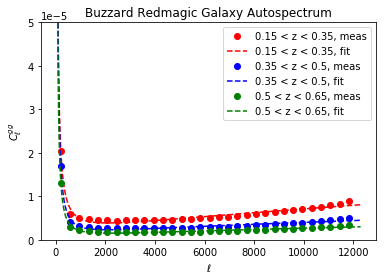

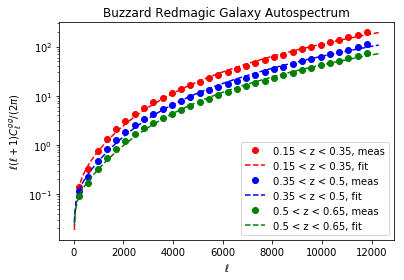

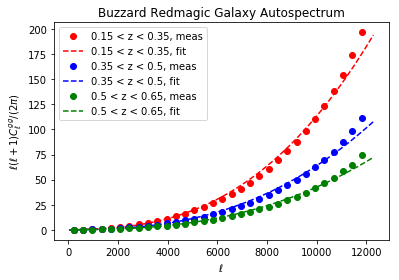

<Figure size 432x288 with 0 Axes>

In [7]:
gg_bin1_meas = cl_gg_meas[:,0]
gg_bin2_meas = cl_gg_meas[:,1]
gg_bin3_meas = cl_gg_meas[:,2]

A = .01
b = -1
C = 0
d = .05


# # fit sum of 2 power laws to each bin, low ell
# gg_pars1_lowl, gg_cov1_lowl = curve_fit(sum_2_plaws, ells[0:6], gg_bin1_meas[0:6], [A, b, C, d])
# gg_pars2_lowl, gg_cov2_lowl = curve_fit(sum_2_plaws, ells[0:6], gg_bin2_meas[0:6], [A, b, C, d])
# gg_pars3_lowl, gg_cov3_lowl = curve_fit(sum_2_plaws, ells[0:6], gg_bin3_meas[0:6], [A, b, C, d])

# gg_pars1_hil, gg_cov1_hil = curve_fit(plaw, ells[24:], gg_bin1_meas[24:], [-1.42727054, -0.8454608])
# gg_pars2_hil, gg_cov2_hil = curve_fit(plaw, ells[24:], gg_bin2_meas[24:], [-1, -1.2])
# gg_pars3_hil, gg_cov3_hil = curve_fit(plaw, ells[24:], gg_bin3_meas[24:], [-1, -1.2])

# # interpolate in between
# gg1_interp = interp1d(ells[6:26], gg_bin1_meas[6:26])
# gg2_interp = interp1d(ells[6:26], gg_bin2_meas[6:26])
# gg3_interp = interp1d(ells[6:26], gg_bin3_meas[6:26])

# # ells_filled is a range of ells from 0 to ell_max
# ells_filled = np.arange(ell_max)
# cl_gg_fit1  = np.zeros(ell_max)
# cl_gg_fit2  = np.zeros(ell_max)
# cl_gg_fit3  = np.zeros(ell_max)

# switch1 = int(math.ceil(ells[6]))
# switch2 = int(math.floor(ells[25]))

# cl_gg_fit1[ell_min:switch1] = sum_2_plaws(ells_filled[ell_min:switch1], gg_pars1_lowl[0], gg_pars1_lowl[1], gg_pars1_lowl[2], gg_pars1_lowl[3])
# cl_gg_fit2[ell_min:switch1] = sum_2_plaws(ells_filled[ell_min:switch1], gg_pars2_lowl[0], gg_pars2_lowl[1], gg_pars2_lowl[2], gg_pars2_lowl[3])
# cl_gg_fit3[ell_min:switch1] = sum_2_plaws(ells_filled[ell_min:switch1], gg_pars3_lowl[0], gg_pars3_lowl[1], gg_pars3_lowl[2], gg_pars3_lowl[3])

# cl_gg_fit1[switch1:switch2] = gg1_interp(ells_filled[switch1:switch2])
# cl_gg_fit2[switch1:switch2] = gg2_interp(ells_filled[switch1:switch2])
# cl_gg_fit3[switch1:switch2] = gg3_interp(ells_filled[switch1:switch2])

# cl_gg_fit1[switch2:] = plaw(ells_filled[switch2:], gg_pars1_hil[0], gg_pars1_hil[1])
# cl_gg_fit2[switch2:] = plaw(ells_filled[switch2:], gg_pars2_hil[0], gg_pars2_hil[1])
# cl_gg_fit3[switch2:] = plaw(ells_filled[switch2:], gg_pars3_hil[0], gg_pars3_hil[1])


# plt.plot(ells_filled,cl_gg_fit1, 'r', linestyle='--')
# plt.plot(ells, gg_bin1_meas, 'ro', label = '0.15 < z < 0.35, meas')
# plt.plot(ells_filled,cl_gg_fit2, 'b', linestyle='--')
# plt.plot(ells, gg_bin2_meas, 'bo', label = '0.35 < z < 0.5, meas')
# plt.plot(ells_filled,cl_gg_fit3, 'g', linestyle='--')
# plt.plot(ells, gg_bin3_meas, 'go', label = '0.5 < z < 0.65, meas')
# plt.show()
# plt.clf()

# plt.semilogy(ells_filled,get_yaxis(ells_filled,cl_gg_fit1), 'r', linestyle='--')
# plt.semilogy(ells, get_yaxis(ells, gg_bin1_meas), 'ro', label = '0.15 < z < 0.35, meas')
# plt.semilogy(ells_filled,get_yaxis(ells_filled,cl_gg_fit2), 'b', linestyle='--')
# plt.semilogy(ells, get_yaxis(ells, gg_bin2_meas), 'bo', label = '0.35 < z < 0.5, meas')
# plt.semilogy(ells_filled,get_yaxis(ells_filled,cl_gg_fit3), 'g', linestyle='--')
# plt.semilogy(ells, get_yaxis(ells, gg_bin3_meas), 'go', label = '0.5 < z < 0.65, meas')


# the fits are for the range (ell_min, ell_max). Later I'll add the 0:ell_min

ells_filled = np.arange(ell_min,ell_max)
cl_gg1_fit  = np.zeros(ell_max-ell_min)
cl_gg2_fit  = np.zeros(ell_max-ell_min)
cl_gg3_fit  = np.zeros(ell_max-ell_min)

gg_pars1, gg_cov1 = curve_fit(sum_2_plaws, ells, gg_bin1_meas, [A, b, C, d])
gg_pars2, gg_cov2 = curve_fit(sum_2_plaws, ells, gg_bin2_meas, [A, b, C, d])
gg_pars3, gg_cov3 = curve_fit(sum_2_plaws, ells, gg_bin3_meas, [A, b, C, d])

cl_gg1_fit = sum_2_plaws(ells_filled, gg_pars1[0], gg_pars1[1], gg_pars1[2], gg_pars1[3])
cl_gg2_fit = sum_2_plaws(ells_filled, gg_pars2[0], gg_pars2[1], gg_pars2[2], gg_pars2[3])
cl_gg3_fit = sum_2_plaws(ells_filled, gg_pars3[0], gg_pars3[1], gg_pars3[2], gg_pars3[3])

plt.plot(ells, gg_bin1_meas, 'ro', label = '0.15 < z < 0.35, meas')
plt.plot(ells_filled, cl_gg1_fit, 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.plot(ells, gg_bin2_meas, 'bo', label = '0.35 < z < 0.5, meas')
plt.plot(ells_filled, cl_gg2_fit, 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.plot(ells, gg_bin3_meas, 'go', label = '0.5 < z < 0.65, meas')
plt.plot(ells_filled, cl_gg3_fit, 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.ylabel("$C_\ell^{gg}$")
plt.xlabel("$\ell$")
plt.ylim([0,5e-5])
plt.title("Buzzard Redmagic Galaxy Autospectrum")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()
plt.clf()

plt.semilogy(ells, get_yaxis(ells, gg_bin1_meas), 'ro', label = '0.15 < z < 0.35, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gg1_fit), 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.semilogy(ells, get_yaxis(ells, gg_bin2_meas), 'bo', label = '0.35 < z < 0.5, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gg2_fit), 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.semilogy(ells, get_yaxis(ells, gg_bin3_meas), 'go', label = '0.5 < z < 0.65, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gg3_fit), 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.ylabel("$\ell(\ell+1)C_\ell^{gg}/(2\pi)$")
plt.xlabel("$\ell$")
plt.title("Buzzard Redmagic Galaxy Autospectrum")
plt.show()
plt.clf()

plt.plot(ells, get_yaxis(ells, gg_bin1_meas), 'ro', label = '0.15 < z < 0.35, meas')
plt.plot(ells_filled, get_yaxis(ells_filled, cl_gg1_fit), 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.plot(ells, get_yaxis(ells, gg_bin2_meas), 'bo', label = '0.35 < z < 0.5, meas')
plt.plot(ells_filled, get_yaxis(ells_filled, cl_gg2_fit), 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.plot(ells, get_yaxis(ells, gg_bin3_meas), 'go', label = '0.5 < z < 0.65, meas')
plt.plot(ells_filled, get_yaxis(ells_filled, cl_gg3_fit), 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.ylabel("$\ell(\ell+1)C_\ell^{gg}/(2\pi)$")
plt.xlabel("$\ell$")
plt.title("Buzzard Redmagic Galaxy Autospectrum")
plt.show()
plt.clf()

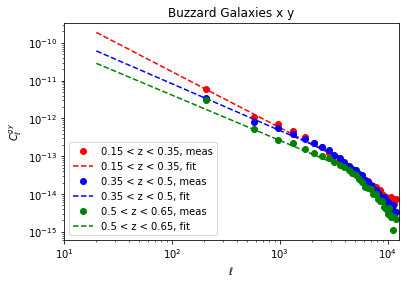

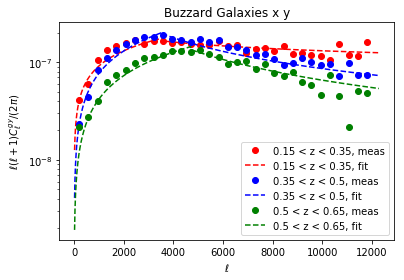

(-1e-12, 5e-11)

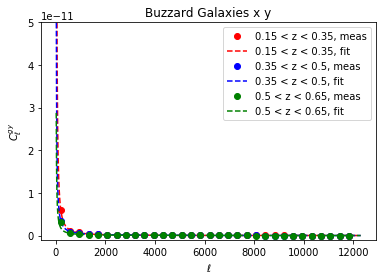

In [8]:
gy_bin1_meas = cl_gy_meas[:,0]
gy_bin2_meas = cl_gy_meas[:,1]
gy_bin3_meas = cl_gy_meas[:,2]

A1 = 10**-6
b1 = -2e-5
C1 = -10**-7
d1 = 3e-6

A2 = 10**-6
b2 = 1e-5
C2 = -10**-7
d2 = 1e-6

A3 = 10**-6
b3 = -2e-5
C3 = -10**-7
d3 = 1e-6

ell_switch1 = 9
ell_switch2 = 9
ell_switch3 = 12
switch1 = int(math.floor(ells[ell_switch1]))
switch2 = int(math.floor(ells[ell_switch2]))
switch3 = int(math.floor(ells[ell_switch3]))

cl_gy1_fit  = np.zeros(ell_max-ell_min)
cl_gy2_fit  = np.zeros(ell_max-ell_min)
cl_gy3_fit  = np.zeros(ell_max-ell_min)

#fit broken power law to each bin
gy_pars1_lowl, gy_cov1_lowl = curve_fit(plaw, ells[:ell_switch1], gy_bin1_meas[:ell_switch1], [A1, b1])
gy_pars2_lowl, gy_cov2_lowl = curve_fit(plaw, ells[:ell_switch2], gy_bin2_meas[:ell_switch2], [A2, b2])
gy_pars3_lowl, gy_cov3_lowl = curve_fit(plaw, ells[:ell_switch3]*1.08, gy_bin3_meas[:ell_switch3]/1.3, [A3, b3])

gy_pars1_hil, gy_cov1_hil = curve_fit(plaw, ells[ell_switch1:], gy_bin1_meas[ell_switch1:], [A1, b1])
gy_pars2_hil, gy_cov2_hil = curve_fit(plaw, ells[ell_switch2:], gy_bin2_meas[ell_switch2:], [A2, b2])
gy_pars3_hil, gy_cov3_hil = curve_fit(plaw, ells[ell_switch3:], gy_bin3_meas[ell_switch3:], [A3, b3])

cl_gy1_fit[:(switch1-ell_min)] = plaw(ells_filled[:(switch1-ell_min)], gy_pars1_lowl[0], gy_pars1_lowl[1])
cl_gy2_fit[:(switch2-ell_min)] = plaw(ells_filled[:(switch2-ell_min)], gy_pars2_lowl[0], gy_pars2_lowl[1])
cl_gy3_fit[:(switch3-ell_min)] = plaw(ells_filled[:(switch3-ell_min)], gy_pars3_lowl[0]/13, gy_pars3_lowl[1]/1.33)

cl_gy1_fit[(switch1-ell_min):] = plaw(ells_filled[(switch1-ell_min):], gy_pars1_hil[0], gy_pars1_hil[1])
cl_gy2_fit[(switch2-ell_min):] = plaw(ells_filled[(switch2-ell_min):], gy_pars2_hil[0]*10, gy_pars2_hil[1]*1.11)
cl_gy3_fit[(switch3-ell_min):] = plaw(ells_filled[(switch3-ell_min):], gy_pars3_hil[0], gy_pars3_hil[1])


plt.loglog(ells, gy_bin1_meas, 'ro', label = '0.15 < z < 0.35, meas')
plt.loglog(ells_filled, cl_gy1_fit, 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.loglog(ells, gy_bin2_meas, 'bo', label = '0.35 < z < 0.5, meas')
plt.loglog(ells_filled, cl_gy2_fit, 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.loglog(ells, gy_bin3_meas, 'go', label = '0.5 < z < 0.65, meas')
plt.loglog(ells_filled, cl_gy3_fit, 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.xlim([10**1, 10**4.1])
plt.ylabel("$C_\ell^{gy}$")
plt.xlabel("$\ell$")
plt.title("Buzzard Galaxies x y")
plt.show()
plt.clf()

plt.semilogy(ells, get_yaxis(ells, gy_bin1_meas), 'ro', label= '0.15 < z < 0.35, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gy1_fit), 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.semilogy(ells, get_yaxis(ells, gy_bin2_meas), 'bo', label = '0.35 < z < 0.5, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gy2_fit), 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.semilogy(ells, get_yaxis(ells, gy_bin3_meas), 'go', label = '0.5 < z < 0.65, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gy3_fit), 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.ylabel("$\ell(\ell+1)C_\ell^{gy}/(2\pi)$")
plt.xlabel("$\ell$")
plt.title("Buzzard Galaxies x y")
plt.show()
plt.clf()

plt.plot(ells, gy_bin1_meas, 'ro', label= '0.15 < z < 0.35, meas')
plt.plot(ells_filled, cl_gy1_fit, 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.plot(ells, gy_bin2_meas, 'bo', label = '0.35 < z < 0.5, meas')
plt.plot(ells_filled, cl_gy2_fit, 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.plot(ells, gy_bin3_meas, 'go', label = '0.5 < z < 0.65, meas')
plt.plot(ells_filled, cl_gy3_fit, 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.ylabel("$C_\ell^{gy}$")
plt.xlabel("$\ell$")
# plt.xlim([2000,6000])
plt.title("Buzzard Galaxies x y")
plt.ylim([-1e-12,5e-11])

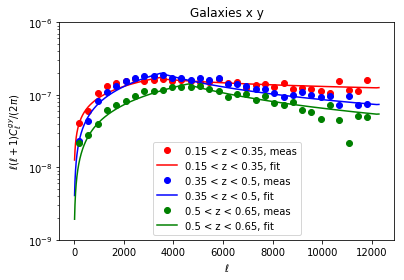

Text(0.5,1,'Galaxies x y')

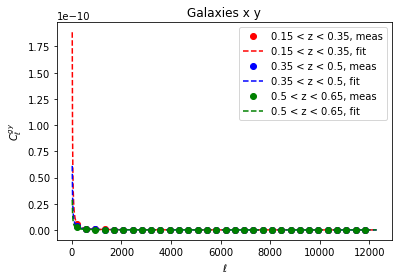

In [9]:
cl_gy1_fit_smth = mov_avg(cl_gy1_fit, 100)
cl_gy2_fit_smth = mov_avg(cl_gy2_fit, 100)
cl_gy3_fit_smth = mov_avg(cl_gy3_fit, 100)

cl_gy1_fit_smth = np.concatenate((cl_gy1_fit[0:2000], cl_gy1_fit_smth[2000:]))
cl_gy2_fit_smth = np.concatenate((cl_gy2_fit[0:2000], cl_gy2_fit_smth[2000:]))
cl_gy3_fit_smth = np.concatenate((cl_gy3_fit[0:2000], cl_gy3_fit_smth[2000:]))

plt.semilogy(ells, get_yaxis(ells, gy_bin1_meas), 'ro', label= '0.15 < z < 0.35, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gy1_fit_smth), 'r', label='0.15 < z < 0.35, fit')
plt.semilogy(ells, get_yaxis(ells, gy_bin2_meas), 'bo', label = '0.35 < z < 0.5, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gy2_fit_smth), 'b', label='0.35 < z < 0.5, fit')
plt.semilogy(ells, get_yaxis(ells, gy_bin3_meas), 'go', label = '0.5 < z < 0.65, meas')
plt.semilogy(ells_filled, get_yaxis(ells_filled, cl_gy3_fit_smth), 'g', label='0.5 < z < 0.65, fit')
plt.legend()
plt.ylim([10**-9, 10**-6])
plt.ylabel("$\ell(\ell+1)C_\ell^{gy}/(2\pi)$")
plt.xlabel("$\ell$")
plt.title("Galaxies x y")
plt.show()
plt.clf()

plt.plot(ells, gy_bin1_meas, 'ro', label= '0.15 < z < 0.35, meas')
plt.plot(ells_filled, cl_gy1_fit_smth, 'r', label='0.15 < z < 0.35, fit', linestyle='--')
plt.plot(ells, gy_bin2_meas, 'bo', label = '0.35 < z < 0.5, meas')
plt.plot(ells_filled, cl_gy2_fit_smth, 'b', label='0.35 < z < 0.5, fit', linestyle='--')
plt.plot(ells, gy_bin3_meas, 'go', label = '0.5 < z < 0.65, meas')
plt.plot(ells_filled, cl_gy3_fit, 'g', label='0.5 < z < 0.65, fit', linestyle='--')
plt.legend()
plt.ylabel("$C_\ell^{gy}$")
plt.xlabel("$\ell$")
# plt.xlim([2000,6000])
plt.title("Galaxies x y")
# plt.ylim([0,2e-13])

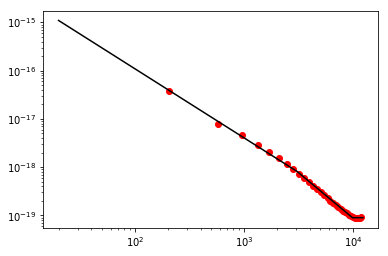

In [10]:
p1_amp_guess = 10**-13.1
p2_amp_guess = 10**-11.5
exp1_guess   = -1.43
exp2_guess   = -1.89
p3_amp_guess = 9e-20
exp3_guess   = 0

Clyy_guess = broken_plaw_3(ells_filled, p1_amp_guess, exp1_guess, p2_amp_guess, exp2_guess, p3_amp_guess, exp3_guess)
plt.loglog(ells, cl_yy_meas, 'ro')
plt.loglog(ells_filled, Clyy_guess, 'k')


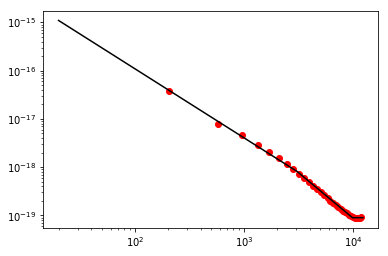

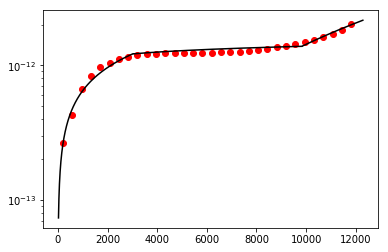

(0, 2e-17)

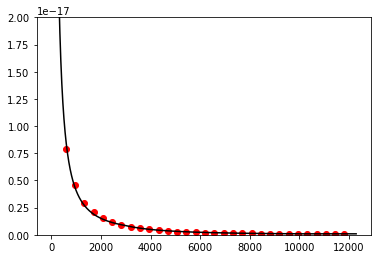

In [11]:
# yy_params, yy_cov = curve_fit(broken_plaw_3, ells, cl_yy_meas, p0=[p1_amp_guess, exp1_guess, p2_amp_guess, exp2_guess, p3_amp_guess, exp3_guess])
Clyy_fit_plaw = Clyy_guess
# broken_plaw_3(ells_filled, yy_params[0], yy_params[1], yy_params[2], yy_params[3], yy_params[4], yy_params[5])
plt.loglog(ells, cl_yy_meas, 'ro')
plt.loglog(ells_filled, Clyy_fit_plaw, 'k')
plt.show()
plt.clf()
plt.semilogy(ells, get_yaxis(ells, cl_yy_meas), 'ro')
plt.semilogy(ells_filled, get_yaxis(ells_filled,Clyy_fit_plaw), 'k')
plt.show()
plt.clf()
plt.plot(ells, cl_yy_meas, 'ro')
plt.plot(ells_filled, Clyy_fit_plaw, 'k')
plt.ylim([0,2e-17])

In [17]:
ells_filled

array([   20,    21,    22, ..., 12285, 12286, 12287])

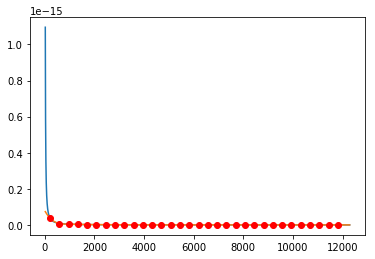

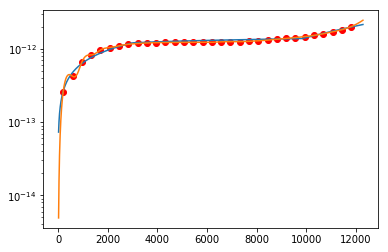

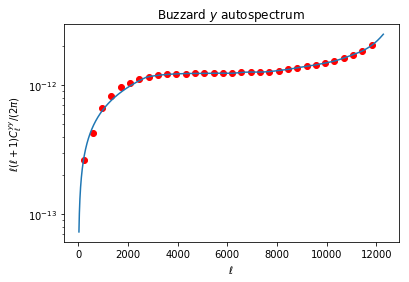

Text(0.5,1,'Buzzard $y$ autospectrum')

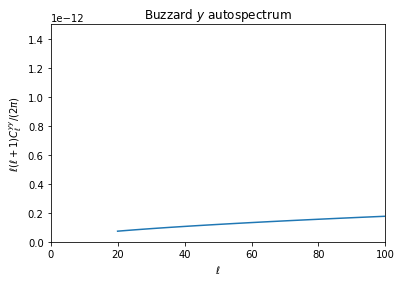

In [16]:
yy_func = interp1d(ells, cl_yy_meas, kind='cubic', bounds_error=False, fill_value="extrapolate")
Clyy_fit = yy_func(ells_filled)
plt.plot(ells_filled, Clyy_fit_plaw)
plt.plot(ells_filled, Clyy_fit)
plt.plot(ells, cl_yy_meas, 'ro')
plt.show()
plt.clf()

plt.semilogy(ells, get_yaxis(ells,cl_yy_meas), 'ro')
plt.semilogy(ells_filled, get_yaxis(ells_filled,Clyy_fit_plaw))
plt.semilogy(ells_filled, get_yaxis(ells_filled,Clyy_fit))
plt.show()
plt.clf()

ells_intersect = 2700

Clyy_comb = Clyy_fit
Clyy_comb[:2700] = Clyy_fit_plaw[:2700]

plt.semilogy(ells, get_yaxis(ells,cl_yy_meas), 'ro')
plt.semilogy(ells_filled, get_yaxis(ells_filled,Clyy_comb))
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_\ell^{yy}/(2\pi)$")
plt.title("Buzzard $y$ autospectrum")
plt.show()
plt.clf()

plt.plot(ells, get_yaxis(ells,cl_yy_meas), 'ro')
plt.plot(ells_filled, get_yaxis(ells_filled,Clyy_comb))
plt.ylim([0,1.5e-12])
plt.xlim([0,100])
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_\ell^{yy}/(2\pi)$")
plt.title("Buzzard $y$ autospectrum")

In [38]:
# save fits
all_info = (ells_filled, cl_gg1_fit, cl_gg2_fit, cl_gg3_fit, cl_gy1_fit, cl_gy2_fit, cl_gy3_fit, Clyy_comb)
all_info_complete = []
i = 0
for arr in all_info:
    if i==0:
        all_info_complete.append(np.concatenate((np.arange(ell_min),arr)))
    else:
        all_info_complete.append(np.concatenate((np.zeros(ell_min),arr)))
    i+=1
np.savetxt("/mnt/raid-cita/mlokken/buzzard/cls_buzzard_for_healpy.txt", np.asarray(all_info_complete).T)

In [42]:
np.asarray(all_info_complete).T[:,1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       8.06656270e-06, 8.06697024e-06, 8.06737776e-06])

In [18]:

# A = 1
# b = -.2
# C = 1
# d = -.2

# def one_plaw(x, A, b):
#     return A*x**b

# ells_filled_bw = np.arange(int(round(ells[0])), ells[len(ells)-1], 1.)

# if mode == "ACT":
#     # #fit sum of 2 power laws to each bin
#     yy_pars_low, yy_cov_low = curve_fit(one_plaw, ells[0:3], cl_yy_meas[0:3], [A,b])
#     yy_pars_hi, yy_cov_hi = curve_fit(one_plaw, ells[12:], cl_yy_meas[12:], [A,b])
#     plt.plot(ells, cl_yy_meas, 'ro')
#     plt.plot(ells, one_plaw(ells_filled, yy_pars_low[0], yy_pars_low[1]), 'r', linestyle='--', label='low-$\ell$ fit')
#     plt.plot(ells, one_plaw(ells_filled, yy_pars_hi[0], yy_pars_hi[1]), 'k', linestyle='--', label='high-$\ell$ fit')
#     plt.plot(ells_filled_bw, yy_func(ells_filled_bw), label='interpolation')
#     plt.title("ACT y")
# if mode == "Buzzard":
#     plt.plot(ells, cl_yy_meas, 'ro')
#     yy_pars_low, yy_cov_low = curve_fit(one_plaw, ells[0:3], cl_yy_meas[0:3], [A,b])
#     yy_pars_hi,  yy_cov_hi  = curve_fit(one_plaw, ells[len(ells)-4:len(ells)-1], cl_yy_meas[len(ells)-4:len(ells)-1], [A,b])
#     plt.plot(ells_filled, one_plaw(ells_filled, yy_pars_low[0], yy_pars_low[1]), 'r', linestyle='--', label='low-$\ell$ fit')
#     plt.plot(ells_filled_bw, yy_func(ells_filled_bw), label='interpolation')
#     plt.plot(ells_filled, one_plaw(ells_filled, yy_pars_hi[0], yy_pars_hi[1]), 'k', linestyle='dotted', label='hi-$\ell$ fit')
#     plt.title("Buzzard y")
#     plt.ylim([0,1e-16])
#     plt.ylabel("$C_\ell^{yy}$")
#     plt.xlabel("$\ell$")
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))    
#     plt.show()
#     plt.clf()
#     plt.legend()
    
#     plt.semilogy(ells, get_yaxis(ells,cl_yy_meas), 'ro')
#     plt.semilogy(ells_filled, get_yaxis(ells_filled,one_plaw(ells_filled, yy_pars_low[0], yy_pars_low[1]/1.01)), 'r', linestyle='--', label='low-$\ell$ fit')
#     plt.semilogy(ells_filled_bw, get_yaxis(ells_filled_bw, yy_func(ells_filled_bw)), label='interpolation')
#     plt.semilogy(ells_filled, get_yaxis(ells_filled, one_plaw(ells_filled, yy_pars_hi[0], yy_pars_hi[1])), 'k', linestyle='dotted', label='hi-$\ell$ fit')
#     plt.title("Buzzard y")
#     plt.ylabel("$\ell(\ell+1)C_\ell^{yy}/2\pi$")
#     plt.xlabel("$\ell$")
#     plt.legend()
#     plt.show()
#     plt.clf()




In [19]:
# if mode == "ACT":
#     plt.semilogy(ells, get_yaxis(ells, cl_yy_meas), 'ro')
#     # plt.semilogy(ells_filled[20:200], get_yaxis(ells_filled[20:200], one_plaw(ells_filled[20:200], yy_pars_low[0], yy_pars_low[1])), 'r', linestyle='--')
#     # plt.semilogy(ells_filled[4700:], get_yaxis(ells_filled[4700:], one_plaw(ells_filled[4700:], yy_pars_hi[0], yy_pars_hi[1])), 'r', linestyle='--')
#     # plt.semilogy(ells_filled_bw, get_yaxis(ells_filled_bw, yy_func(ells_filled_bw)), 'b')
#     cl_yy_fit = np.zeros(max_ell)
#     cl_yy_fit[ell_min:210]=one_plaw(ells_filled[ell_min:210], yy_pars_low[0], yy_pars_low[1])
#     cl_yy_fit[209:4799]=yy_func(ells_filled_bw[10:])
#     cl_yy_fit[4799:] = one_plaw(ells_filled[4799:], yy_pars_hi[0], yy_pars_hi[1])
#     plt.plot(ells_filled, get_yaxis(ells_filled,cl_yy_fit))
# if mode == "Buzzard":
#     cl_yy_fit = np.zeros(ell_max-ell_min)
# #     cl_yy_fit[:int(ells[1])] = one_plaw(ells_filled[:int(ells[1])], yy_pars_low[0], yy_pars_low[1]/1.01)
#     cl_yy_fit[int(ells[0]):int(max(ells))-500] = yy_func(ells_filled[int(ells[0]):int(max(ells))-500])
#     cl_yy_fit[int(max(ells))-500:] = one_plaw(ells_filled[int(max(ells))-500:], yy_pars_hi[0], yy_pars_hi[1])
#     replace = mov_avg(cl_yy_fit[40:], 20)
#     cl_yy_fit[40:] = replace
#     cl_yy_fit[0:40] = 0
# #     plt.semilogy(ells_filled,get_yaxis(ells_filled,cl_yy_fit))
# #     plt.semilogy(ells, get_yaxis(ells, cl_yy_meas), 'ro')
# #     plt.clf()
#     plt.plot(ells_filled,cl_yy_fit)
#     plt.plot(ells, cl_yy_meas, 'ro')

# plt.ylabel("$\ell(\ell+1) C_\ell^{yy}/(2\pi)$")
# plt.xlabel("$\ell$")

# # plt.ylim([0, 5e-17])
# plt.xlim([0,2000])

# plt.title("{:s} y".format(mode))

# # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# Make the GRF maps

In [21]:
# y_enmap = enmap.read_map("/mnt/scratch-lustre/mlokken/data/act_ymaps/tilec_single_tile_deep56_comptony_map_v1.2.0_joint.fits")
# shape, wcs = y_enmap.shape, y_enmap.wcs
# gmap_out1 = curvedsky.rand_map(shape, wcs, ps=cl_gg1_fit, lmax=nside*3, spin=0)
# gmap_out2 = curvedsky.rand_map(shape, wcs, ps=cl_gg2_fit, lmax=nside*3, spin=0)
# gmap_out3 = curvedsky.rand_map(shape, wcs, ps=cl_gg3_fit, lmax=nside*3, spin=0)
gmap_out1 = hp.synfast((Clyy_comb, cl_gg1_fit, cl_gy1_fit), nside=nside, new=True, pol=False)
# gmap_out2 = hp.synfast((Clyy_comb, cl_gg2_fit, cl_gy2_fit), nside=nside, new=True, pol=False)
# gmap_out3 = hp.synfast((Clyy_comb, cl_gg3_fit, cl_gy3_fit), nside=nside, new=True, pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


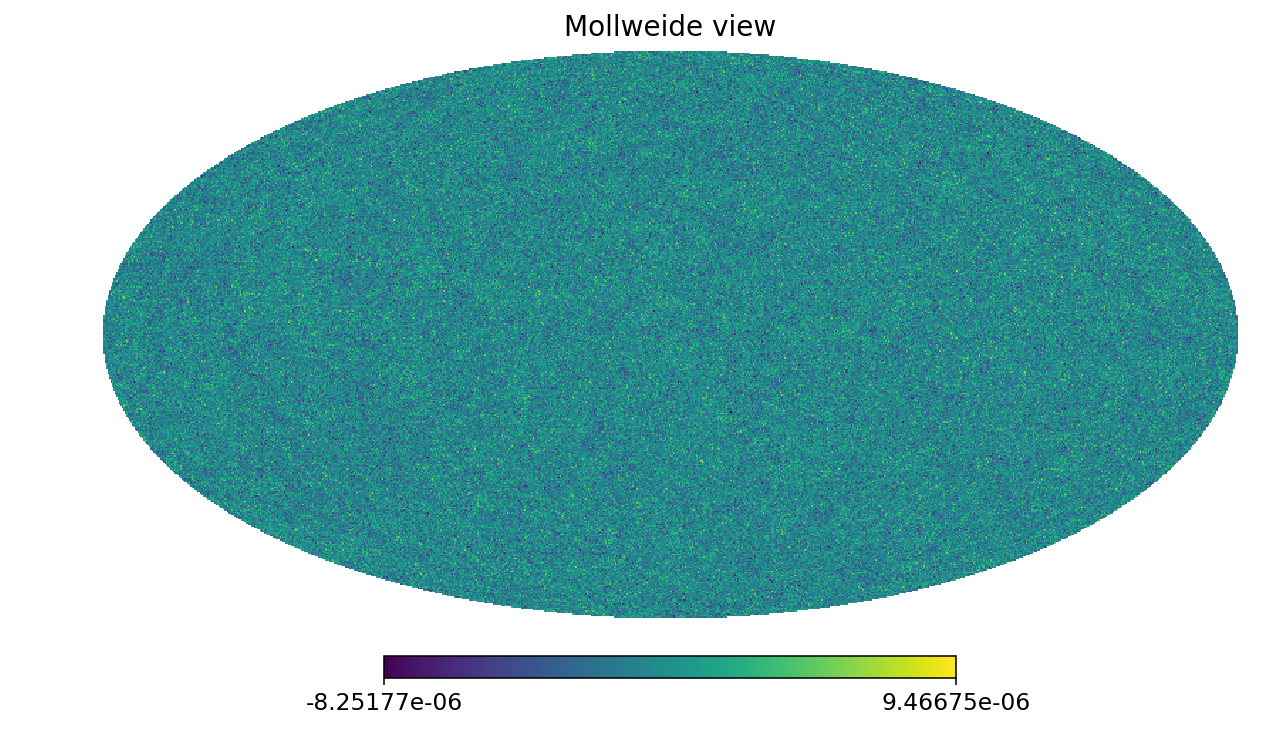

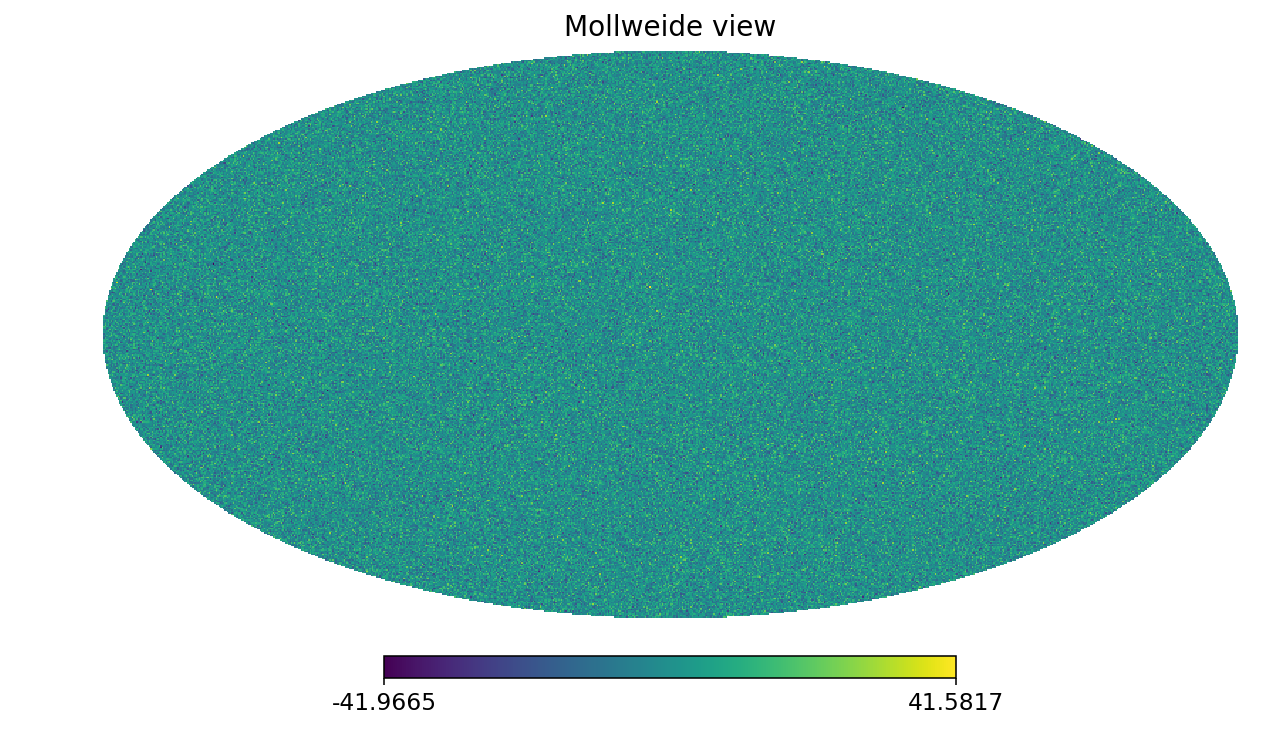

In [22]:
hp.mollview(gmap_out1[0])
hp.mollview(gmap_out1[1])

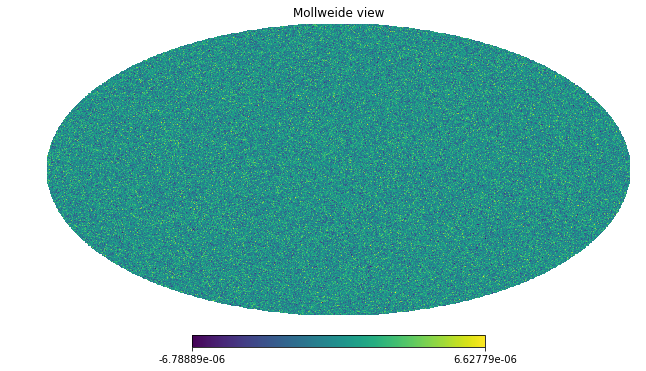

In [19]:
if mode == 'Buzzard':
    hp.mollview(gmap_out2[0])
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_galfield_pandeyfit_rmagic_mybuzzardyy_zbin1.fits", gmap_out1[1])
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_yfield_pandeyfit_rmagic_mybuzzardyy_zbin1.fits", gmap_out1[0])
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_galfield_pandeyfit_rmagic_mybuzzardyy_zbin2.fits", gmap_out2[1])
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_yfield_pandeyfit_rmagic_mybuzzardyy_zbin2.fits", gmap_out2[0])
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_galfield_pandeyfit_rmagic_mybuzzardyy_zbin3.fits", gmap_out3[1])
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_yfield_pandeyfit_rmagic_mybuzzardyy_zbin3.fits", gmap_out3[0])
elif mode == 'ACT':    
    redmagic_mask = hp.read_map("/mnt/scratch-lustre/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
    hp.mollview(gmap_out2[0] * redmagic_mask)
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_galfield_pandeyfit_rmagic_act_zbin1_wmask.fits", gmap_out1[1]*redmagic_mask)
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_yfield_pandeyfit_rmagic_act_zbin1_wmask.fits", gmap_out1[0]*redmagic_mask)
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_galfield_pandeyfit_rmagic_act_zbin2_wmask.fits", gmap_out2[1]*redmagic_mask)
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_yfield_pandeyfit_rmagic_act_zbin2_wmask.fits", gmap_out2[0]*redmagic_mask)
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_galfield_pandeyfit_rmagic_act_zbin3_wmask.fits", gmap_out3[1]*redmagic_mask)
    hp.write_map("/mnt/scratch-lustre/mlokken/stacking/GRF/grf_yfield_pandeyfit_rmagic_act_zbin3_wmask.fits", gmap_out3[0]*redmagic_mask)

In [24]:
ymap_out = hp.read_map("/mnt/raid-cita/mlokken/grf/grf_yfield_buzzardspec_zbin1_2.fits")
gmap_out = hp.read_map("/mnt/raid-cita/mlokken/grf/grf_gfield_buzzardspec_zbin1_2.fits")

/home/mlokken/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [16]:
ymap_out2 = hp.read_map("/mnt/raid-cita/mlokken/grf/grf_yfield_buzzardspec_zbin1_14.fits")
gmap_out2 = hp.read_map("/mnt/raid-cita/mlokken/grf/grf_gfield_buzzardspec_zbin1_14.fits")

/home/mlokken/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


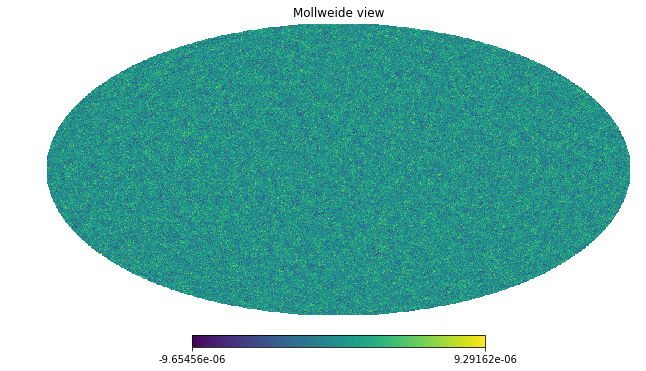

In [17]:
hp.mollview(ymap_out)

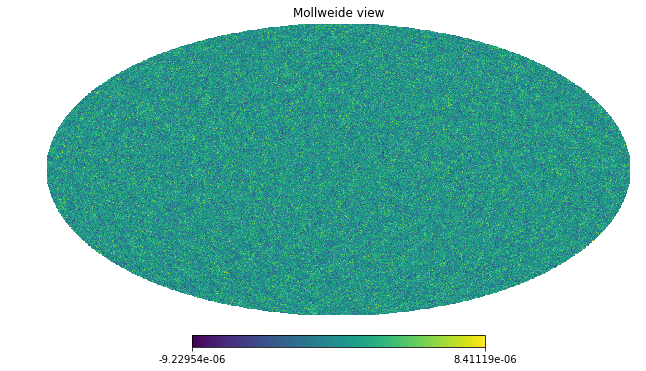

In [18]:
hp.mollview(ymap_out2)

In [9]:
ymap_out2-ymap_out

array([-1.97765155e-06, -7.11432563e-07,  2.69432084e-06, ...,
       -2.19007723e-06,  5.97260499e-08, -3.98915091e-07])

In [25]:
ells, ycorr = get_cls(ymap_out, 4096)

Doing cross correlations...



In [26]:
ells, gcorr = get_cls(gmap_out, 4096)

Doing cross correlations...



In [27]:
ells, xcorr = get_cls(ymap_out, 4096, gmap_out)

Doing cross correlations...



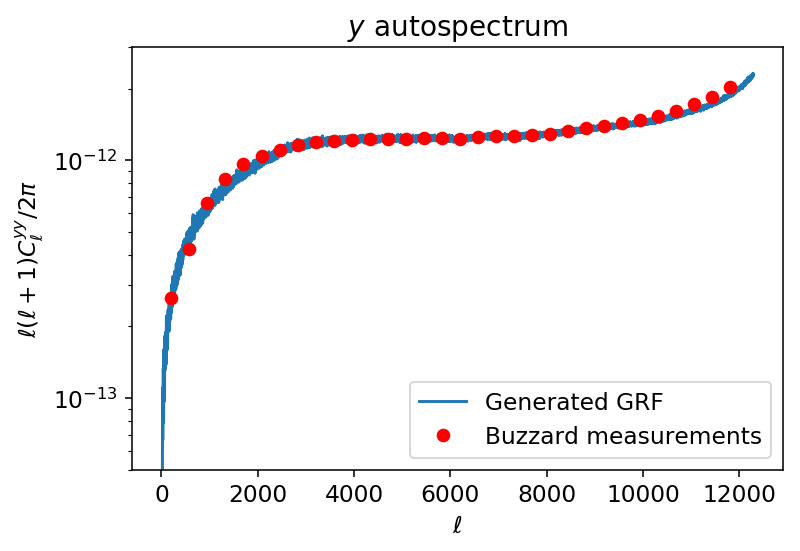

In [67]:
plt.semilogy(np.arange(4096*3), get_yaxis(np.arange(4096*3), ycorr), label='Generated GRF')
plt.semilogy(ells, get_yaxis(ells,cl_yy_meas), 'ro', label='Buzzard measurements')
plt.ylabel("$\ell(\ell+1) C_\ell^{yy}/2\pi$")
plt.xlabel("$\ell$")
plt.title("$y$ autospectrum")
plt.ylim([5e-14, 3e-12])
plt.legend()
# plt.ylim([10**-14,10**-11])

Text(0,0.5,'$\\ell(\\ell+1) C_\\ell^{gg}/2\\pi$')

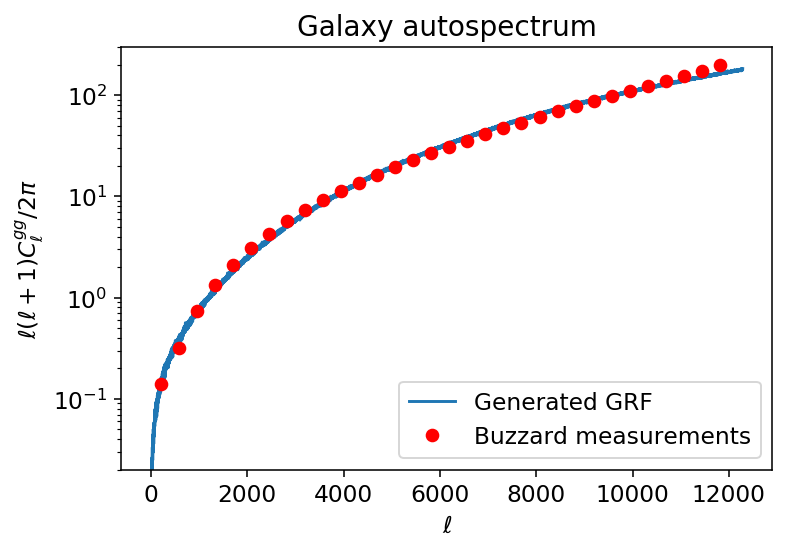

In [71]:
plt.semilogy(np.arange(4096*3), get_yaxis(np.arange(4096*3),gcorr), label="Generated GRF")
plt.semilogy(ells, get_yaxis(ells, cl_gg_meas[:,0]), 'ro', label="Buzzard measurements")
plt.title("Galaxy autospectrum")
plt.ylim([2*10**-2, 3*10**2])
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1) C_\ell^{gg}/2\pi$")

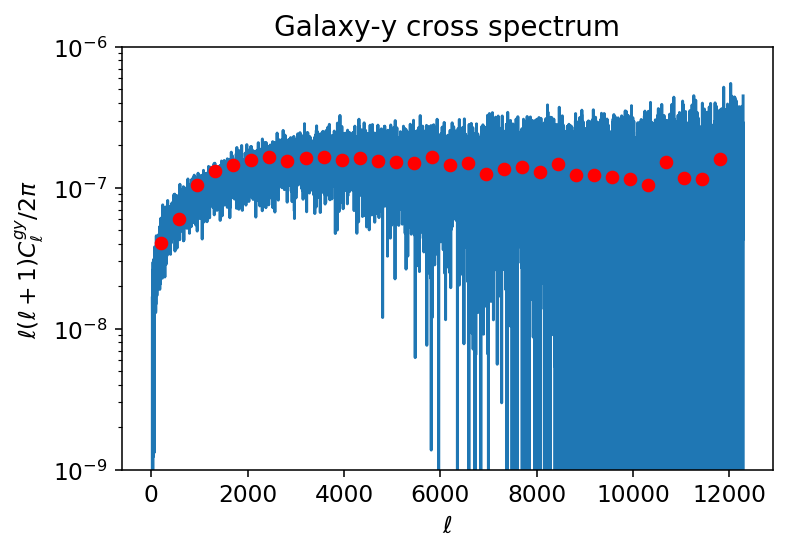

Text(0.5,0,'$\\ell$')

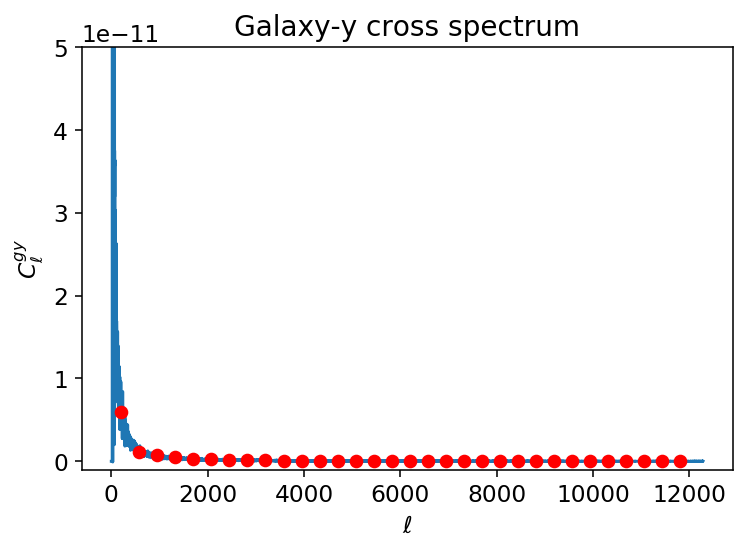

In [83]:
plt.semilogy(np.arange(4096*3), get_yaxis(np.arange(4096*3),xcorr))
plt.semilogy(ells, get_yaxis(ells,cl_gy_meas[:,0]), 'ro')
plt.ylim([10**-9,10**-6])
plt.ylabel("$\ell(\ell+1) C_\ell^{gy}/2\pi$")
plt.title("Galaxy-y cross spectrum")
plt.xlabel("$\ell$")
plt.show()
plt.clf()

plt.plot(np.arange(4096*3), xcorr)
plt.plot(ells, cl_gy_meas[:,0], 'ro')
plt.ylim([-1e-12,5e-11])
plt.ylabel("$C_\ell^{gy}$")
plt.title("Galaxy-y cross spectrum")
plt.xlabel("$\ell$")

In [ ]:
redmagic_mask = hp.read_map("/mnt/scratch-lustre/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
redmagic_mask = hp.ud_grade(redmagic_mask, 1024)
hp.write_map("/mnt/scratch-lustre/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx_1024.fit", redmagic_mask)

In [ ]:
rm_hdu = fits.open("/mnt/scratch-lustre/mlokken/buzzard/catalogs/buzzard_1.9.9_3y3a_rsshift_run_redmagic_highdens.fit")
rm     = rm_hdu[1].data
rm_ra  = rm['RA']
rm_dec = rm['dec']
rm_z   = rm['zredmagic']
rm_hdu.close()

redmagic_mask = hp.read_map("/mnt/scratch-lustre/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_30a_smth.fits")

# zlow = z_at_value(cosmo.comoving_distance, dlow*u.Mpc)
# zhi  = z_at_value(cosmo.comoving_distance, dhigh*u.Mpc)
# galra = rm_ra[(zlow<rm_z) & (rm_z<zhi)]
# galdec= rm_dec[(zlow<rm_z) & (rm_z<zhi)]
galra = rm_ra
galdec = rm_dec

In [ ]:
mean_ng, galmap = get_hp_map(nside,galra,galdec, rm_mask)


In [ ]:
# ell_min = round(2*np.pi / width)
ell_min = 30
print(ell_min)
redmagic_mask_sq_mean = np.mean(redmagic_mask**2)
print(redmagic_mask_sq_mean)

In [ ]:
ells, cl_gg = get_cls(galmap, nside)
cl_gg = cl_gg / redmagic_mask_sq_mean
cl_gg[0:ell_min] = 0

In [ ]:
plt.plot(ells, cl_gg,'g')
plt.title("all z, galmap autospectrum")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.xlim([0,200])


In [ ]:
cl_gg_smth = mov_avg(cl_gg, 10)

In [ ]:
plt.semilogy(ells, cl_gg_smth,'g')
plt.title("all z, galmap autospectrum")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.xlim([0,200])

In [ ]:
cl_yy_smth = mov_avg(cl_yy, 10)
plt.plot(ells, cl_yy_smth*ells**2/(2*np.pi),'g')
plt.title("Buzzard $y$ autospectrum")
plt.xlabel("$\ell$")
plt.ylabel("$\ell^2 C_\ell^{yy}$ / 2$\pi$")
plt.xlim ([0,5000])

In [ ]:
ells, cl_gy = get_cls(galmap, nside, ymap_masked)
cl_gy = cl_gy / mask_sq_mean
cl_gy[0:ell_min] = 0

In [ ]:
cl_gy_smth = mov_avg(cl_gy, 10)
plt.plot(ells, cl_gy_smth,'g')
plt.title("galaxy - y cross spectrum")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell^{gy}$")
plt.xlim([0,3000])

In [ ]:
ps = np.zeros((2, 2,len(ells)))
ps[0,0] = cl_yy_smth
ps[1,1] = cl_gg_smth
ps[0,1] = cl_gy_smth
ps[1,0] = ps[0,1]

Just make one galaxy map, no cross correlation

In [ ]:
y_enmap = enmap.read_map("/mnt/scratch-lustre/mlokken/data/act_ymaps/tilec_single_tile_deep56_comptony_map_v1.2.0_joint.fits")
shape, wcs = y_enmap.shape, y_enmap.wcs
gmap_out = curvedsky.rand_map(shape, wcs, ps=cl_gg_smth, lmax=nside*3, spin=0)

In [ ]:
enplot.show(enplot.plot(gmap_out))

In [ ]:
hp_map_gonly = rp.healpix_from_enmap(gmap_out, nside=nside, lmax=nside*3)
hp.mollview(hp_map_gonly)
hp.mollview(galmap)

In [ ]:
act_mask = hp.read_map("/mnt/scratch-lustre/mlokken/data/act_ymaps/tilec_mask_4096_hpx.fits")
act_mask = hp.ud_grade(act_mask, nside)
mask_sq_mean_act = np.mean(act_mask**2)

In [ ]:
hp.write_map("/mnt/scratch-lustre/mlokken/data/act_ymaps/tilec_mask_1024_hpx.fits", act_mask)

In [ ]:
ells, cl_gg_out = get_cls((hp_map_gonly)*act_mask, nside)
cl_gg_out = cl_gg_out / mask_sq_mean_act


In [ ]:
plt.plot(ells, cl_gg_out,'g', label='GRF')
plt.plot(ells, cl_gg_smth, 'k', label='RedMaGiC, all $z$')
plt.title("Autospectrum of RedMaGiC field and corresponding GRF")
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.xlim([0,1000])

In [ ]:
hp.write_map("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/grf_gg_allz_actreg.fits", hp_map_gonly, overwrite=True)

In [ ]:
y_enmap = enmap.read_map("/mnt/scratch-lustre/mlokken/data/act_ymaps/tilec_single_tile_deep56_comptony_map_v1.2.0_joint.fits")
shape, wcs = y_enmap.shape, y_enmap.wcs
# shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(20./60.))
shape = (2, shape[0], shape[1])
omap = curvedsky.rand_map(shape,wcs,ps=ps,lmax=nside*3,spin=0)


In [ ]:
hp_map_y = rp.healpix_from_enmap(omap[0], nside=nside, lmax=nside*3)
hp_map_g = rp.healpix_from_enmap(omap[1], nside=nside, lmax=nside*3)
hp.mollview(hp_map_y)
hp.mollview(hp_map_g)
hp.write_map("/mnt/scratch-lustre/mlokken/stacking/y_GRF/gaussian_yfield_allz.fits", hp_map_y, overwrite=True)
hp.write_map("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/gaussian_galfield_allz.fits", hp_map_g, overwrite=True)

In [ ]:
# mask_map = np.ones(hp.nside2npix(nside))
# all_pix = np.arange(hp.nside2npix(nside))
# theta,phi = hp.pix2ang(nside, all_pix)
# maxtheta = 1.73
# mintheta = 1.5
# theta_cond = np.logical_or(theta > maxtheta,theta < mintheta)
# phi_cond = np.logical_and(phi < 6.1, phi > 0.75)
# masked_pix = all_pix[np.logical_or((theta_cond), (phi_cond))]
# mask_map[masked_pix] = 0.
# mask_map = hp.sphtfunc.smoothing(mask_map, fwhm = np.deg2rad(4/60.))
# masked_y_omap = hp_map_y * mask_map
# mask_sq_mean_2 = np.mean(mask_map**2)
# hp.cartview(hp_map_y, lonra=[-20,60], latra=[-15,10])
# hp.cartview(masked_y_omap, lonra=[-20,60], latra=[-15,10])
# hp.cartview(mask_map, lonra=[-20,60], latra=[-15,10])

In [ ]:
ells, cl_yy_out = get_cls(masked_y_omap, nside)
cl_yy_out = cl_yy_out / mask_sq_mean_act


In [ ]:
ells, cl_gy_out = get_cls(masked_g_omap, nside, masked_y_omap)
cl_gy_out = cl_gy_out / mask_sq_mean_act

In [ ]:
ells, cl_gg_out = get_cls(masked_g_omap, nside)
cl_gg_out = cl_gg_out / mask_sq_mean_act

In [ ]:
plt.plot(ells, cl_yy_out*ells**2/(2*np.pi),'g', label='GRF')
plt.plot(ells, cl_yy_smth*ells**2/(2*np.pi),'k', label='original')
plt.title("ymap autospectrum after")
plt.xlabel("$\ell$")
plt.ylabel("$\ell^2 C_\ell^{yy}$ / 2$\pi$")
plt.xlim([0,4000])

plt.legend()

In [ ]:
plt.plot(ells, cl_gy_out, 'g', label='GRF')
plt.plot(ells, cl_gy_smth, 'k', label='original')

plt.legend()
plt.title("galaxy - y cross spectrum after")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell^{gy}$")
plt.xlim([0,800])

In [ ]:
plt.plot(ells, cl_gg_out,'g', label='GRF')
plt.plot(ells, cl_gg, 'k', label='original')
plt.title("all z, galmap autospectrum after")
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.xlim([0,500])

In [ ]:
hp.write_map("/mnt/scratch-lustre/mlokken/stacking/y_GRF/gaussian_yfield_actreg.fits", hp_map_y)
hp.write_map("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/gaussian_galfield_actreg_.fits", hp_map_g)

All- Healpy version

In [ ]:
maps = hp.sphtfunc.synfast((ps[0,0], ps[1,1], ps[0,1]), 4096, new=True, pol=False)

In [ ]:
ymap_out = maps[0]
galmap_out = maps[1]
hp.mollview(ymap_out)
hp.mollview(galmap_out)

In [ ]:
masked_ymap_out = rm_mask * ymap_out
masked_galmap_out = rm_mask * galmap_out

hp.mollview(masked_ymap_out)

In [ ]:
ells, cl_yy_out = get_cls(masked_ymap_out, nside)
cl_yy_out = cl_yy_out / mask_sq_mean

In [ ]:
plt.semilogy(ells, cl_yy_out*ells**2/(2*np.pi),'g', label='GRF')
plt.semilogy(ells, cl_yy_smth*ells**2/(2*np.pi),'k', label='original')
plt.title("ymap autospectrum after")
plt.xlabel("$\ell$")
plt.ylabel("$\ell^2 C_\ell^{yy}$ / 2$\pi$")
plt.xlim([0,5000])

plt.legend()

In [ ]:
ells, cl_gy_out = get_cls(masked_g_omap, nside, masked_y_omap)
cl_gy_out = cl_gy_out / mask_sq_mean_2
cl_gy[0:ell_min] = 0

In [ ]:
hdr,img,npks = cpp.get_img("/mnt/scratch-lustre/mlokken/stacking/y_GRF/stacks/y_grf_ong_allz_nug2pt2_3arcmin.fits", "/mnt/scratch-lustre/mlokken/stacking/gal_GRF/peaks/grf_allz_nugt2pt2.fits")


radius_deg = float(hdr['RADIUS'][1:])*u.deg

res        = float(hdr['RES'][1:])
arcmin_per_pix = radius_deg.to(u.arcmin) / res

fig = plt.figure(figsize=[7,6]) 
smoothplot = plt.imshow(np.flipud(ndimage.gaussian_filter(img, sigma=8)), cmap='afmhot')
locs = []
for i in range(9):
    locs.append(i/8. * img.shape[0])

labels = ['','','','']
for loc in locs[4:]:
    labels.append(round((loc-img.shape[0]//2) * arcmin_per_pix.value))

plt.xlabel("x [arcmin]")
plt.ylabel("y [arcmin]")
plt.xticks(locs, labels)
plt.yticks(locs, labels)

cbar = fig.colorbar(smoothplot)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label('$y$')
cbar.update_ticks()



In [ ]:
npks

In [ ]:
hdr,img,npks = cpp.get_img("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/stacks/grf_gg_allz_nugt2on3arcmin.fits", "/mnt/scratch-lustre/mlokken/stacking/gal_GRF/peaks/grf_allz_nugt2.fits")


radius_deg = float(hdr['RADIUS'][1:])*u.deg
res        = float(hdr['RES'][1:])
arcmin_per_pix = radius_deg.to(u.arcmin) / res

fig = plt.figure(figsize=[7,6]) 
smoothplot = plt.imshow(np.flipud(ndimage.gaussian_filter(img, sigma=8)), cmap='RdBu_r')
locs = []
for i in range(9):
    locs.append(i/8. * img.shape[0])

labels = ['','','','']
for loc in locs[4:]:
    labels.append(round((loc-img.shape[0]//2) * arcmin_per_pix.value))

plt.xlabel("x [arcmin]")
plt.ylabel("y [arcmin]")
plt.xticks(locs, labels)
plt.yticks(locs, labels)

cbar = fig.colorbar(smoothplot)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label('$n_{gal}$')
cbar.update_ticks()


In [ ]:
shape,wcs = enmap.fullsky_geometry(res=np.deg2rad(20./60.))
shape = (3,) + shape